In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from scipy import linalg
import scipy.integrate as integrate
from scipy.special import gamma
import time

from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture._gaussian_mixture import _estimate_log_gaussian_prob, _compute_precision_cholesky, _estimate_gaussian_covariances_full
from sklearn.utils import check_random_state
from sklearn import cluster
from sklearn.model_selection import KFold

import pandas as pd
from astropy.stats import sigma_clip
from scipy.stats import median_abs_deviation as mad

### Shapes 3D

In [51]:
# plot histogram with highest MI values
# first axis is label number, second axis is latent
all_MI_estimates = np.load('./shapes3D/MI_latents_labels.npy')
# these are from Lillian
beta2zdim6 = np.array([[0.0059155279794872164, 0.004425910215880301, 2.287343894399798, 0.004839882827017868, 0.00679878532434249, 0.015799111780296048],
                        [0.005291229773551627, 0.015401339350013865, 0.009326005135168024, 0.00576129665361449, 2.203242207071432, 0.015403195223842458],
                        [1.9313108691241967, 0.00706888997987716, 0.006802767957196686, 0.009614998217507302, 0.0042501708818623914, 0.016258122784980563],
                        [0.0046770068772649396, 0.18480622639093533, 0.007659799371723874, 0.5030696404705941, 0.029697928817851237, 0.010870909376811781],
                        [0.006490616998417474, 0.1410466939916793, 0.00802751293843795, 0.2828802819790144, 0.013277517860019936, 0.009239727270775265],
                        [0.007467694377759076, 0.010331056805112286, 0.012748510071551408, 0.00549790574357622, 0.032007430087424, 2.2785308522806096]])

beta2zdim6_latent_ordering = np.array([3, 6, 5, 1, 4, 2])
beta2zdim6_factor_ordering = [0, 5, 1, 2, 3, 4]
beta2zdim6_arr = beta2zdim6[:, beta2zdim6_latent_ordering - 1]
beta2zdim6_arr = beta2zdim6_arr[beta2zdim6_factor_ordering, :]

beta2zdim6 = np.roll(beta2zdim6, 1, axis=0)
sorted_args_lillian = np.argsort(beta2zdim6)[:, -2:]

In [52]:
label_list = ['wall_hue', 'floor_hue', 'object_hue', 'orientation', 'scale', 'shape'] # careful: rolled wall_hue at the beginning
all_MI_estimates_m = np.mean(all_MI_estimates, axis=-1)
all_MI_estimates_m = np.roll(all_MI_estimates_m, 1, axis=0)
all_MI_estimates_s = np.std(all_MI_estimates, axis=-1)
all_MI_estimates_s = np.roll(all_MI_estimates_s, 1, axis=0)

sorted_args = np.argsort(all_MI_estimates_m)[:, -2:]

latent_colour_scheme = ['#b35806','#f1a340','#fee0b6','#d8daeb','#998ec3','#542788']
#['#CC6677', '#DDCC77', '#117733', '#88CCEE', '#882255', '#999933']

(array([31.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([4.72791973e-05, 9.10339426e-04, 1.77339966e-03, 2.63645988e-03,
        3.49952011e-03, 4.36258034e-03, 5.22564057e-03, 6.08870080e-03,
        6.95176103e-03, 7.81482126e-03, 8.67788149e-03]),
 <a list of 10 Patch objects>)

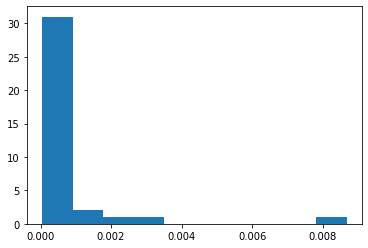

In [53]:
plt.hist(all_MI_estimates_s.flatten())

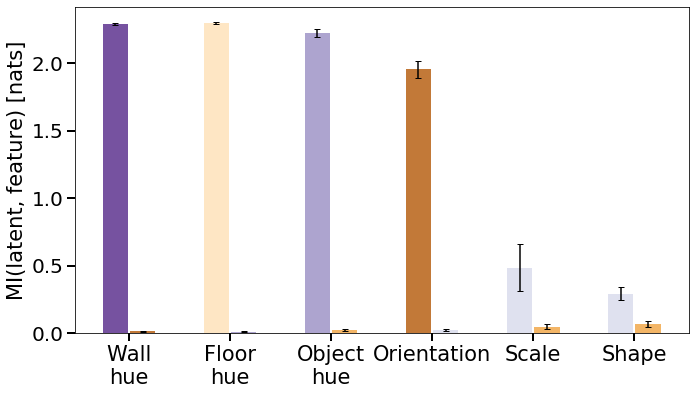

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(11, 6))
width = 0.50/2
alpha = 0.8
yerr_mul = 20
x = np.arange(len(label_list))  # the label locations

#rects1 = ax.bar(x+width/2 , 
#                np.choose(sorted_args_lillian[:, 0], beta2zdim6.T), 
#                width, color=np.choose(sorted_args_lillian[:, 0], latent_colour_scheme),
#                alpha=alpha, hatch='\\'
#                #yerr=np.choose(sorted_args[:, 1], all_MI_estimates_s.T),
#     )

#rects1 = ax.bar(x - 1.5*width-2*0.01, 
#                np.choose(sorted_args_lillian[:, 1], beta2zdim6.T), 
#                width, color=np.choose(sorted_args_lillian[:, 1], latent_colour_scheme),
#                alpha=alpha, hatch='\\',
#                #yerr=np.choose(sorted_args[:, 1], all_MI_estimates_s.T),
#     )

rects2 = ax.bar(x - width/2-0.01, 
                np.choose(sorted_args[:, 1], all_MI_estimates_m.T), 
                width, color=np.choose(sorted_args[:, 1], latent_colour_scheme),
                alpha=alpha,
                yerr=yerr_mul*np.choose(sorted_args[:, 1], all_MI_estimates_s.T), capsize=3
     )
rects3 = ax.bar(x + width/2+0.01, 
       [value*20 if value < 0.01 else value for value in np.choose(sorted_args[:, 0], all_MI_estimates_m.T) ], 
        width, color=np.choose(sorted_args[:, 0], latent_colour_scheme),
                alpha=alpha, yerr=yerr_mul*np.choose(sorted_args[:, 0], all_MI_estimates_s.T), capsize=3

     )
    
#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

ax.tick_params(axis='x', which='major', labelsize=21, length=10, width=2, size=8)
ax.tick_params(axis='y', which='major', labelsize=20, length=10, width=2, size=8)
ax.set_ylabel(f'MI(latent, feature) [nats]', fontsize=21)

ax.set_xticks(x)
ax.set_xticklabels([label.capitalize().replace("_", "\n") for label in label_list])

# build legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor=latent_colour_scheme[i], label=f'Latent {i+1}') for i in range(6)]

#leg = ax.legend(handles=legend_elements, fontsize=30, frameon=False);
#for lh in leg.legendHandles: 
#    lh.set_alpha(alpha)
fig.savefig('./figures/MI_shapes3D.pdf', bbox_inches='tight');

In [55]:
# same, but with heatmap

In [56]:
# plot histogram with highest MI values
# first axis is label number, second axis is latent
all_MI_estimates = np.load('./shapes3D/MI_latents_labels.npy')
# these are from Lillian
beta2zdim6 = np.array([[0.0059155279794872164, 0.004425910215880301, 2.287343894399798, 0.004839882827017868, 0.00679878532434249, 0.015799111780296048],
                        [0.005291229773551627, 0.015401339350013865, 0.009326005135168024, 0.00576129665361449, 2.203242207071432, 0.015403195223842458],
                        [1.9313108691241967, 0.00706888997987716, 0.006802767957196686, 0.009614998217507302, 0.0042501708818623914, 0.016258122784980563],
                        [0.0046770068772649396, 0.18480622639093533, 0.007659799371723874, 0.5030696404705941, 0.029697928817851237, 0.010870909376811781],
                        [0.006490616998417474, 0.1410466939916793, 0.00802751293843795, 0.2828802819790144, 0.013277517860019936, 0.009239727270775265],
                        [0.007467694377759076, 0.010331056805112286, 0.012748510071551408, 0.00549790574357622, 0.032007430087424, 2.2785308522806096]])

beta2zdim6_latent_ordering = np.array([3, 6, 5, 1, 4, 2])
beta2zdim6_factor_ordering = [0, 5, 1, 2, 3, 4]
beta2zdim6_arr = beta2zdim6[:, beta2zdim6_latent_ordering - 1]
beta2zdim6_arr = beta2zdim6_arr[beta2zdim6_factor_ordering, :]

beta2zdim6 = np.roll(beta2zdim6, 1, axis=0)
sorted_args_lillian = np.argsort(beta2zdim6)[:, -2:]

In [57]:
label_list = ['wall_hue', 'floor_hue', 'object_hue', 'orientation', 'scale', 'shape'] # careful: rolled wall_hue at the beginning
all_MI_estimates_m = np.mean(all_MI_estimates, axis=-1)
all_MI_estimates_m = np.roll(all_MI_estimates_m, 1, axis=0)
all_MI_estimates_s = np.std(all_MI_estimates, axis=-1)
all_MI_estimates_s = np.roll(all_MI_estimates_s, 1, axis=0)

sorted_args = np.argsort(all_MI_estimates_m)[:, -2:]

latent_colour_scheme = ['#b35806','#f1a340','#fee0b6','#d8daeb','#998ec3','#542788']
#['#CC6677', '#DDCC77', '#117733', '#88CCEE', '#882255', '#999933']

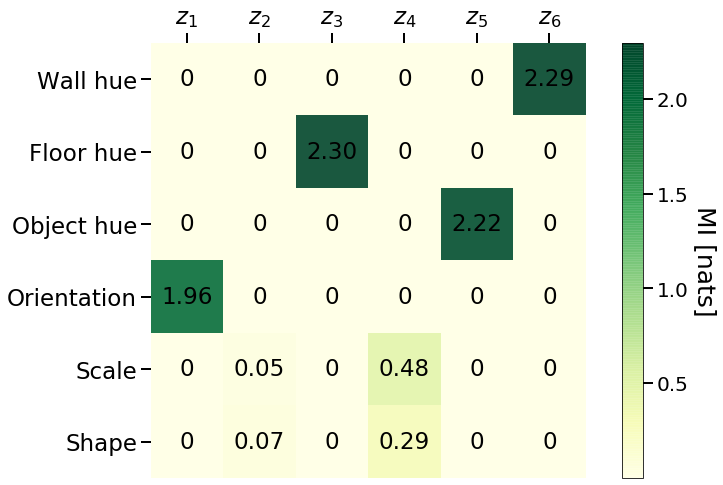

In [59]:
# plot

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

def heatmap(data, row_labels, col_labels, fsize=30, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax, **cbar_kw)
    cbar.ax.tick_params(labelsize=20, length=10, width=2) 
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=25)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(labels=col_labels, fontsize=fsize)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(labels=row_labels, fontsize=fsize)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False, length=10, width=2)

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
    #         rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, gmm_mi_std=None, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()
        

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i, j] < 0.01:
                text = im.axes.text(j, i, matplotlib.ticker.StrMethodFormatter("{x:.0f}")(data[i, j], None), **kw) 
            else:
                #kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

vegetables = [label.capitalize().replace("_", " ") for label in label_list]
farmers = [f"$z_{i}$" for i in range(1, 7)]#[f"$z_{i+$" for i in range(6)]

harvest = all_MI_estimates_m


fig, (ax1) = plt.subplots(1, 1, figsize=(24, 8))


im, cbar = heatmap(harvest, vegetables, farmers, ax=ax1,
                   cmap="YlGn", cbarlabel="MI [nats]", alpha=0.9, fsize=23)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=23)
#fig.tight_layout()
plt.savefig('./figures/MI_shapes3D_hm.pdf', bbox_inches='tight')

In [20]:
all_MI_estimates_m

array([[6.28729930e-04, 6.13152621e-04, 4.85850605e-04, 6.07341147e-04,
        4.57732774e-04, 2.28933610e+00],
       [3.30655948e-04, 3.52582959e-04, 2.29500784e+00, 4.50452214e-04,
        5.44391275e-04, 5.35197628e-04],
       [3.19895069e-04, 1.25555408e-03, 3.53057244e-04, 4.72017085e-04,
        2.22267396e+00, 3.39152809e-04],
       [1.95500989e+00, 5.75835089e-04, 4.08510523e-04, 1.11940241e-03,
        5.01270103e-04, 4.90775748e-04],
       [2.98103675e-04, 4.78504531e-02, 2.73146690e-04, 4.83604477e-01,
        1.87243202e-03, 4.58129904e-04],
       [7.90845796e-05, 6.90157123e-02, 2.46522328e-04, 2.92330021e-01,
        1.74966487e-04, 1.15425389e-04]])

In [23]:
all_MI_estimates_s.min()

4.7279197307931955e-05

### Halo data

In [30]:
KDE_02 = np.load('mi_truth_latents_epoch_27_bw_0.2.npy')[0].T
KDE_03 = np.load('mi_truth_latents_epoch_27_bw_0.3.npy')[0].T
KDE_01 = np.load('mi_truth_latents_epoch_27_bw_0.1.npy')[0].T

MI_radial = np.load('./haloes_MI_latent0_newproc.npy')
MI_radial_one = np.load('./haloes_MI_latent1_newproc.npy')
MI_radial_two = np.load('./haloes_MI_latent2_newproc.npy')

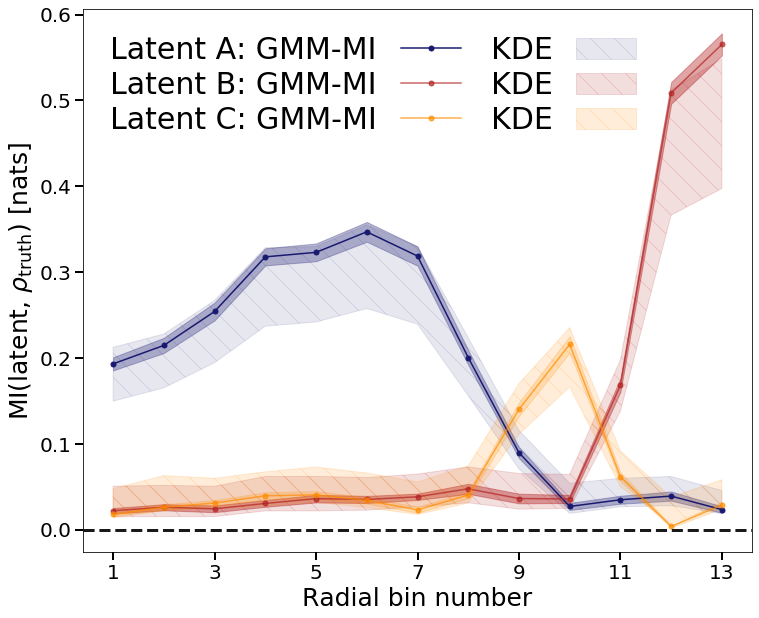

In [32]:
r_bins = 13

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial, axis=1), color='midnightblue', marker='o', markersize=5, alpha=1, label='Latent A: GMM-MI')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial, axis=1)- np.std(MI_radial, axis=1), np.mean(MI_radial, axis=1)+np.std(MI_radial, axis=1), color='midnightblue', alpha=0.3)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 0], color='midnightblue', marker='o', markersize=5, alpha=0.1)
ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 0], KDE_03[:, 0], color='midnightblue', alpha=0.1, label='KDE', hatch="\\")

ax.plot(np.arange(1, 1+r_bins),  np.mean(MI_radial_one, axis=1), color='firebrick', marker='o', markersize=5, alpha=0.7, label='Latent B: GMM-MI')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_one, axis=1)- np.std(MI_radial_one, axis=1), np.mean(MI_radial_one, axis=1)+ np.std(MI_radial_one, axis=1), color='firebrick', alpha=0.4)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 1], color='firebrick', marker='o', markersize=5, alpha=0.1)
ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 1], KDE_03[:, 1], color='firebrick', alpha=0.15, label='KDE', hatch="\\")

ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_two, axis=1), color='darkorange', marker='o', markersize=5, alpha=0.7, label='Latent C: GMM-MI')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_two, axis=1)- np.std(MI_radial_two, axis=1), np.mean(MI_radial_two, axis=1)+ np.std(MI_radial_two, axis=1), color='darkorange', alpha=0.2)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 2], color='darkorange', marker='o', markersize=5, alpha=0.1)
ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 2], KDE_03[:, 2], color='darkorange', alpha=0.15, label='KDE', hatch="\\")


ax.set_xlabel('Radial bin number', fontsize=25)
ax.set_ylabel(r'MI(latent, $\rho_{\rm{truth}}$) [nats]', fontsize=25)

ax.tick_params(axis='both', which='major', labelsize=20, length=10, width=2, size=8)

ax.set_xticks(np.arange(1, 14, 2))
ax.set_xticklabels(np.arange(1, 14, 2))

ax.axhline(0, ls='--', lw=3, color='k', alpha=0.9)
ax.legend(fontsize=30, ncol=2, labelspacing=0.2, columnspacing=1, markerfirst=False, frameon=False)
#ax.set_rasterized(True)
fig.savefig('./figures/MI_trend.pdf', bbox_inches='tight', format='pdf')
#fig.savefig('./figures/MI_trend.eps', bbox_inches='tight')
fig.savefig('./figures/MI_trend.png', bbox_inches='tight', dpi=600);

In [26]:
# also compare to MINE

In [30]:
MI_radial_mine = np.load('./mine-pytorch/mine/MI_halo_latent0_MINE.npy')
MI_radial_mine_one = np.load('./mine-pytorch/mine/MI_halo_latent1_MINE.npy')
MI_radial_mine_two = np.load('./mine-pytorch/mine/MI_halo_latent2_MINE.npy')

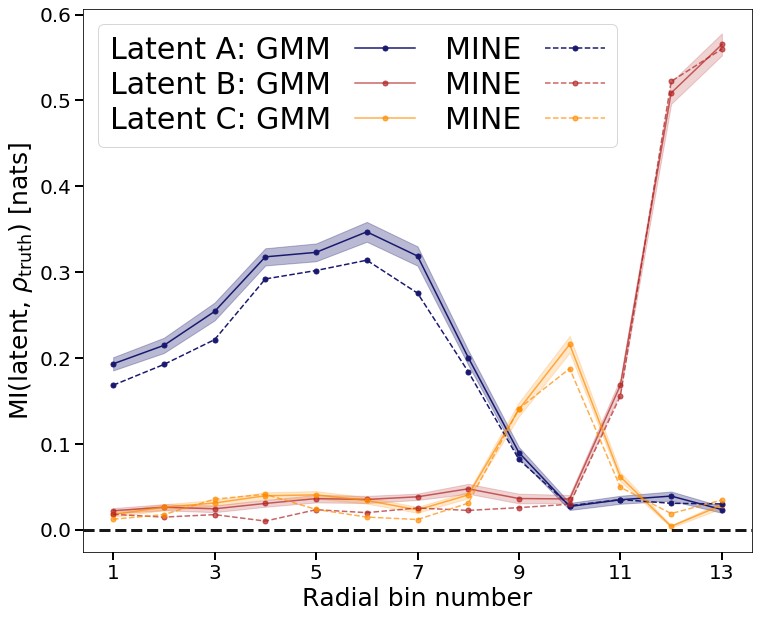

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# latent 0
ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial, axis=1), color='midnightblue', marker='o', markersize=5, alpha=1, label='Latent A: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial, axis=1)- np.std(MI_radial, axis=1), np.mean(MI_radial, axis=1)+np.std(MI_radial, axis=1), color='midnightblue', alpha=0.3)


#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 0], color='midnightblue', marker='o', markersize=5, alpha=0.1)
#ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 0], KDE_03[:, 0], color='midnightblue', alpha=0.1, label='KDE', hatch="\\")


# latent 1
ax.plot(np.arange(1, 1+r_bins),  np.mean(MI_radial_one, axis=1), color='firebrick', marker='o', markersize=5, alpha=0.7, label='Latent B: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_one, axis=1)- np.std(MI_radial_one, axis=1), np.mean(MI_radial_one, axis=1)+ np.std(MI_radial_one, axis=1), color='firebrick', alpha=0.2)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 1], color='firebrick', marker='o', markersize=5, alpha=0.1)
#ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 1], KDE_03[:, 1], color='firebrick', alpha=0.15, label='KDE', hatch="\\")


# latent 2
ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_two, axis=1), color='darkorange', marker='o', markersize=5, alpha=0.7, label='Latent C: GMM')
ax.fill_between(np.arange(1, 1+r_bins), np.mean(MI_radial_two, axis=1)- np.std(MI_radial_two, axis=1), np.mean(MI_radial_two, axis=1)+ np.std(MI_radial_two, axis=1), color='darkorange', alpha=0.2)

#ax.plot(np.arange(1, 1+r_bins), KDE_02[:, 2], color='darkorange', marker='o', markersize=5, alpha=0.1)
#ax.fill_between(np.arange(1, 1+r_bins), KDE_01[:, 2], KDE_03[:, 2], color='darkorange', alpha=0.15, label='KDE', hatch="\\")



ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_mine, axis=1), color='midnightblue', marker='o', ls='--', markersize=5, alpha=1, label='MINE')
ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_mine_one, axis=1), color='firebrick', marker='o', ls='--', markersize=5, alpha=0.7, label='MINE')
ax.plot(np.arange(1, 1+r_bins), np.mean(MI_radial_mine_two, axis=1), color='darkorange', marker='o', ls='--', markersize=5, alpha=0.7, label='MINE')


ax.set_xlabel('Radial bin number', fontsize=25)
ax.set_ylabel(r'MI(latent, $\rho_{\rm{truth}}$) [nats]', fontsize=25)

ax.tick_params(axis='both', which='major', labelsize=20, length=10, width=2, size=8)

ax.set_xticks(np.arange(1, 14, 2))
ax.set_xticklabels(np.arange(1, 14, 2))

ax.axhline(0, ls='--', lw=3, color='k', alpha=0.9)
ax.legend(fontsize=30, ncol=2, labelspacing=0.2, columnspacing=1, markerfirst=False)

fig.savefig('./figures/MI_MINE.pdf', bbox_inches='tight');

### GMM convergence number of components

In [2]:
validation_ll = np.load('./validation_ll.npy')
aics = np.load('./aics.npy')
bics = np.load('./bics.npy')

components_range = 15

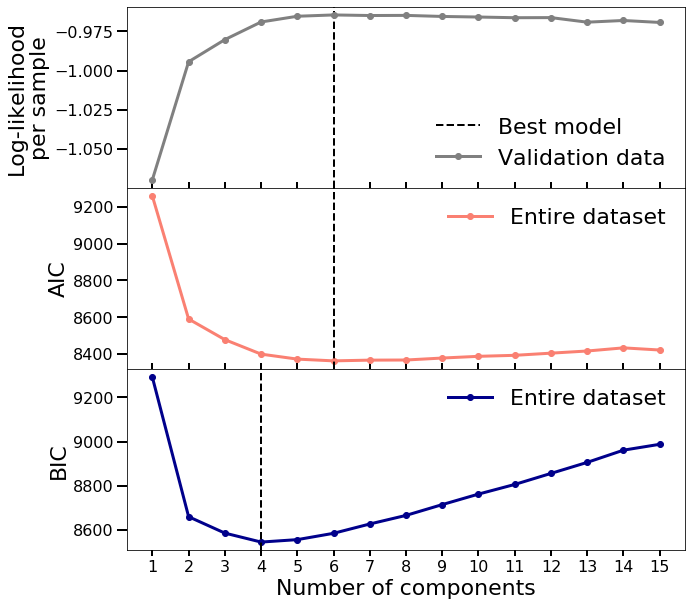

In [6]:
legendsize = 22
labelsize = 16
fig, (ax, ax1, ax2) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

ax.axvline(6, color='k', lw=2, ls='--', label='Best model')
ax.plot(np.arange(1, components_range+1), validation_ll, lw=3, linestyle='-', marker='o', color='grey', label='Validation data')
ax.set_ylabel("Log-likelihood\nper sample", fontsize=legendsize)

ax.set_xticks(np.arange(1, components_range+1))
ax.tick_params(axis='x', which='both', labelsize=labelsize, direction="in", length=6, width=2)
ax.tick_params(axis='y', which='both', labelsize=labelsize, length=10, width=2)

ax.legend(fontsize=legendsize, frameon=False)
#.add_patch(circle1)

ax1.plot(np.arange(1, components_range+1), aics[:], lw=3, linestyle='-', marker='o', color='salmon', label='Entire dataset')
ax1.set_ylabel(r"AIC", fontsize=legendsize)

ax1.tick_params(axis='x', which='both', labelsize=labelsize, direction="in", length=6, width=2)
ax1.tick_params(axis='y', which='both', labelsize=labelsize, length=10, width=2)
ax1.set_xticks(np.arange(1, components_range+1))

#circle1 = matplotlib.patches.Ellipse((6, 5100), 0.5, 40, color='black', fill=False, lw=3)
#ax1.add_patch(circle1);
ax1.axvline(6, color='k', lw=2, ls='--')
ax1.legend(fontsize=legendsize, frameon=False)

ax2.plot(np.arange(1, components_range+1), bics[:], lw=3, linestyle='-', marker='o', color='darkblue', label='Entire dataset')

ax2.set_xlabel('Number of components', fontsize=legendsize)
ax2.set_ylabel(r"BIC", fontsize=legendsize)

ax2.tick_params(axis='x', which='both', labelsize=labelsize, length=6, width=2)
ax2.tick_params(axis='y', which='both', labelsize=labelsize, length=10, width=2)
ax2.set_xticks(np.arange(1, components_range+1))
ax2.axvline(4, color='k', lw=2, ls='--')
ax2.legend(fontsize=legendsize, frameon=False)

plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig('./figures/val_AIC_BIC.pdf', bbox_inches='tight');

### Sedaghat

In [37]:
indices_to_keep = [11, 19, 58, 85, 99, 124]
MI_all = np.load('./astro-machines/standalone_share/MI_all.npy')

MI_values = np.mean(MI_all, axis=-1)[:, indices_to_keep]

(array([12., 11.,  7.,  5.,  0.,  1.,  3.,  1.,  0.,  2.]),
 array([0.00330522, 0.00758393, 0.01186264, 0.01614135, 0.02042007,
        0.02469878, 0.02897749, 0.0332562 , 0.03753491, 0.04181362,
        0.04609233]),
 <a list of 10 Patch objects>)

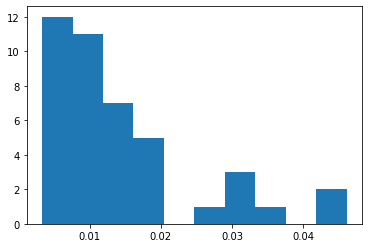

In [38]:
plt.hist(np.std(MI_all, axis=-1)[:, indices_to_keep].flatten())

In [39]:
#--- A simple joint Probability Density Estimator
def pde2(d1,d2,nbins = 10, sigma=0):
    if sigma > 0:
        d1 = sigma_clip(d1,sigma=sigma)
        d2 = sigma_clip(d2,sigma=sigma)
        
    h,_,_ = np.histogram2d(d1,d2,bins=[nbins,nbins])
    h = h / np.sum(h)
    return h

#----------------------------------------------------------------------------
# Mutual information for joint histogram
# from https://matthew-brett.github.io/teaching/mutual_information.html
#----------------------------------------------------------------------------
def mutual_information(hgram): 
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

labels = pd.read_csv('./astro-machines/standalone_share/harps_metadata_and_labels.csv')

codes_file = './astro-machines/standalone_share/encoded_harps_unique_128d_e182_i1500000.npy'
codes = pd.DataFrame(np.load(codes_file))

nDimensions = codes.shape[1]

#--- Compute MADS measures for all latent dimensions
measure = 'median' #or 'mean'
mads_threshold = 0.02
if measure == 'median':
    mads = mad(codes.values) # Median Absolute Deviation
else:
    mads = codes.mad().values # Mean Absolute Deviation

#--- Locate informative/significant dimensions
significant_dimensions = np.nonzero(mads > mads_threshold )[0]
print('Informative dimensions:',significant_dimensions)

#--- If looking at the 'unique' subset, drop unnecessary rows
if "unique" in codes_file:
    labels.dropna(subset=['unique_subset'],inplace=True)

#--- and reindex the codes dataframe accordingly
codes.loc[:,'dp_id'] = labels['dp_id'].values
labels = labels.set_index('dp_id')
codes = codes.set_index('dp_id')

Informative dimensions: [ 11  19  58  85  99 124]


# of labels: 4090


Text(0.5, 1.0, 'MI indicator for radvel')

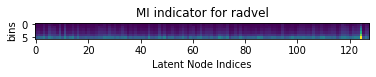

In [40]:
stellar_param = 'radvel' # Choose from ['radvel','Teff','Mass','E(B-V)','[M/H]','airmass','snr','vsini']
label = labels.loc[:,stellar_param].values


#-- Drop NaNs in labels
ind_mask = ~np.isnan(label)

#-- Ignore outlier (most probably erroneous) labels
label_ = sigma_clip(label,sigma=5,masked=True)
ind_mask = ind_mask & (~label_.mask)
label_ = label_.data[ind_mask]
print(f'# of labels: {len(label_)}')


#--- Compute the MI indicator with different binnings
nbinss = [5,10,20,40,80,160]
MI = np.zeros(nDimensions)
MIs = np.zeros([len(nbinss),nDimensions])

for b,nbins in enumerate(nbinss):
    for i in range(nDimensions):
        codes_ = codes.iloc[:,i].values
        codes_ = codes_[ind_mask]
        pqk = pde2(codes_,label_,nbins)
        MI[i] = mutual_information(pqk)
        MIs[b,i] = MI[i]

#--- Normalize MIs
#MIs /= np.max(MIs,1)[:,np.newaxis]

plt.figure()
plt.imshow(MIs);
plt.xlabel('Latent Node Indices')
plt.ylabel('bins')
plt.yticks(None);
plt.title("MI indicator for "+stellar_param)

In [41]:
sed_MI = np.zeros((6, nDimensions))
for k, stellar_param in enumerate(['radvel','Teff','Mass','[M/H]','airmass','snr']):
    label = labels.loc[:,stellar_param].values


    #-- Drop NaNs in labels
    ind_mask = ~np.isnan(label)

    #-- Ignore outlier (most probably erroneous) labels
    label_ = sigma_clip(label,sigma=5,masked=True)
    ind_mask = ind_mask & (~label_.mask)
    label_ = label_.data[ind_mask]
    print(f'# of labels: {len(label_)}')


    #--- Compute the MI indicator with different binnings
    nbinss = [40]
    MI = np.zeros(nDimensions)
    MIs = np.zeros([len(nbinss),nDimensions])

    for b,nbins in enumerate(nbinss):
        for i in range(nDimensions):
            codes_ = codes.iloc[:,i].values
            codes_ = codes_[ind_mask]
            pqk = pde2(codes_,label_,nbins)
            MI[i] = mutual_information(pqk)
            MIs[b,i] = MI[i]
            sed_MI[k, i] = MI[i] 

# of labels: 4090
# of labels: 4293


# of labels: 3351
# of labels: 1932
# of labels: 7007
# of labels: 6988


In [42]:
sed_MI = sed_MI[:, indices_to_keep]

In [43]:
sed_MI[3]

array([0.28191926, 0.2513608 , 0.0880489 , 0.25330127, 0.1900714 ,
       0.31163142])

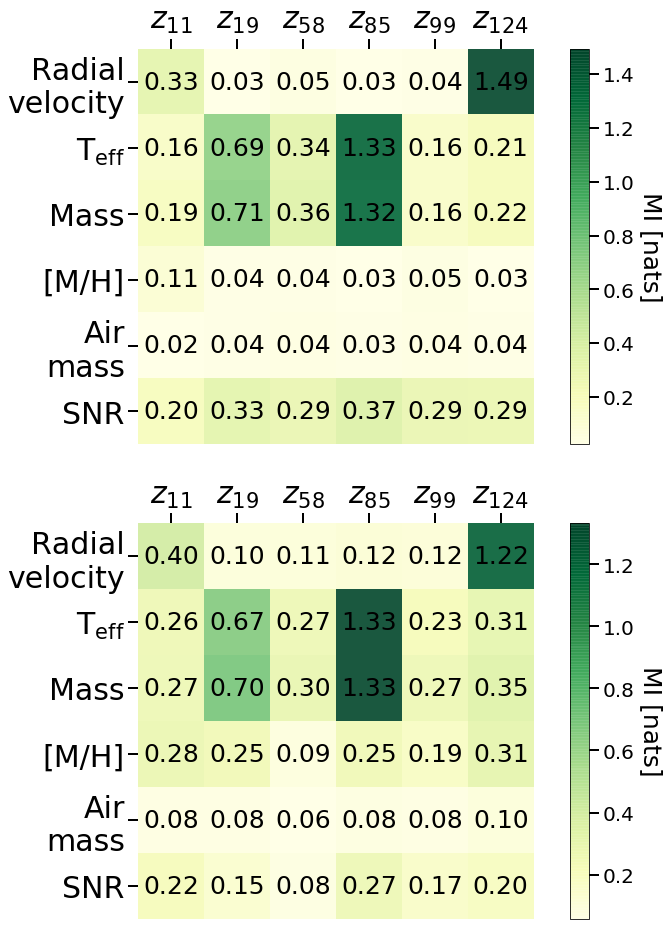

In [44]:
# plot

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

def heatmap(data, row_labels, col_labels, fsize=30, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax, **cbar_kw)
    cbar.ax.tick_params(labelsize=20, length=10, width=2) 
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=25)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(labels=col_labels, fontsize=fsize)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(labels=row_labels, fontsize=fsize)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False, length=10, width=2)

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
    #         rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    
    
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, gmm_mi_std=None, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()
        

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            #if data[i, j] == 0:
            #    continue
            #kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

stellar_params_ = ['Radial\nvelocity','T$_{\mathregular{eff}}$','Mass','[M/H]','Air\nmass','SNR']#,'vsini']
vegetables = stellar_params_
farmers = [f"$z_{{{i}}}$" for i in indices_to_keep]#[f"$z_{i+$" for i in range(6)]

harvest = MI_values[:-1]


fig, (ax, ax1) = plt.subplots(2, 1, figsize=(12, 16))

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="YlGn", cbarlabel="MI [nats]", alpha=0.9)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=25)

harvest = sed_MI

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax1,
                   cmap="YlGn", cbarlabel="MI [nats]", alpha=0.9)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=25)
#fig.tight_layout()
#plt.subplots_adjust(hspace=0)
#plt.savefig('./figures/Sedaghat_MI.pdf', bbox_inches='tight')

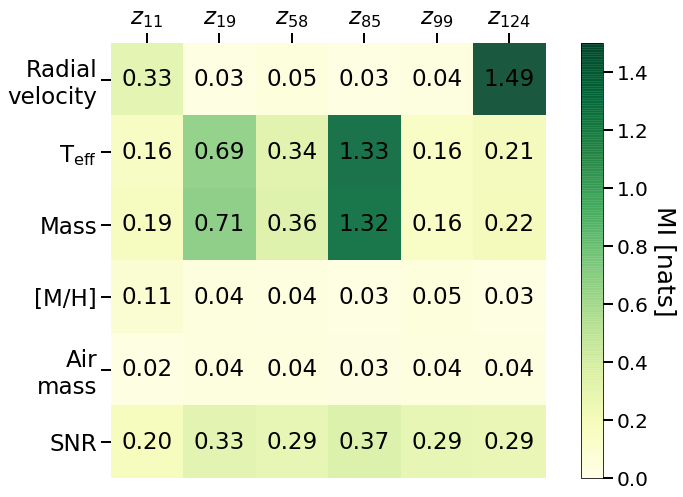

In [47]:
harvest = MI_values[:-1]

fig, (ax) = plt.subplots(1, 1, figsize=(12, 8))

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="YlGn", cbarlabel="MI [nats]", alpha=0.9, vmax=1.5, vmin=0, fsize=23)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=23)

plt.savefig('./figures/Sedaghat_MI_1.pdf', bbox_inches='tight')

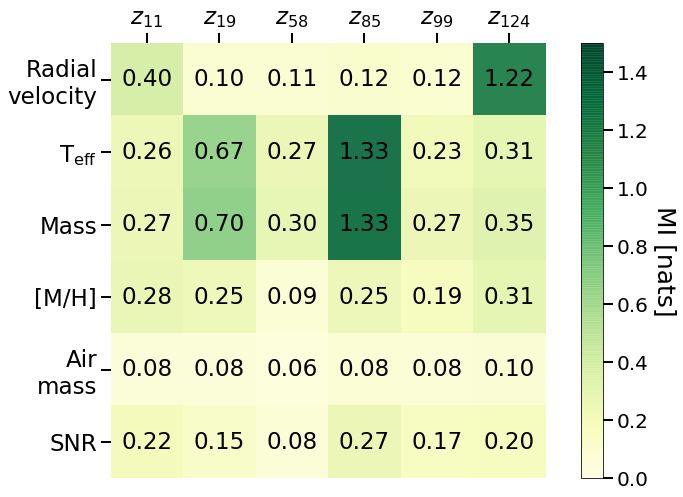

In [48]:
fig, (ax1) = plt.subplots(1, 1, figsize=(24, 8))


harvest = sed_MI

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax1,
                   cmap="YlGn", cbarlabel="MI [nats]", alpha=0.9, vmax=1.5, vmin=0,  fsize=23)
texts = annotate_heatmap(im, valfmt="{x:.2f}", fontsize=23)
#fig.tight_layout()
plt.savefig('./figures/Sedaghat_MI_2.pdf', bbox_inches='tight')

In [ ]:
# attempt to reproduce these figures in a histogram form

In [28]:
# plot histogram with highest MI values
# first axis is label number, second axis is latent
indices_to_keep = [11, 19, 58, 85, 99, 124]
MI_all = np.load('./astro-machines/standalone_share/MI_all.npy')

all_MI_estimates = MI_all[:-1, indices_to_keep, :]

# these are from Sedaghat
sorted_args_sed = np.argsort(sed_MI)[:, -2:]

In [29]:
stellar_params_ = ['Radial\nvelocity','T$_{\mathregular{eff}}$','Mass','[M/H]','Air\nmass','SNR']

label_list = stellar_params_#['wall_hue', 'floor_hue', 'object_hue', 'orientation', 'scale', 'shape'] # careful: rolled wall_hue at the beginning
all_MI_estimates_m = np.mean(all_MI_estimates, axis=-1)
#all_MI_estimates_m = np.roll(all_MI_estimates_m, 1, axis=0)
all_MI_estimates_s = np.std(all_MI_estimates, axis=-1)
#all_MI_estimates_s = np.roll(all_MI_estimates_s, 1, axis=0)

sorted_args = np.argsort(all_MI_estimates_m)[:, -2:]

latent_colour_scheme = ['#b35806','#f1a340','#fee0b6','#d8daeb','#998ec3','#542788']
#['#CC6677', '#DDCC77', '#117733', '#88CCEE', '#882255', '#999933']

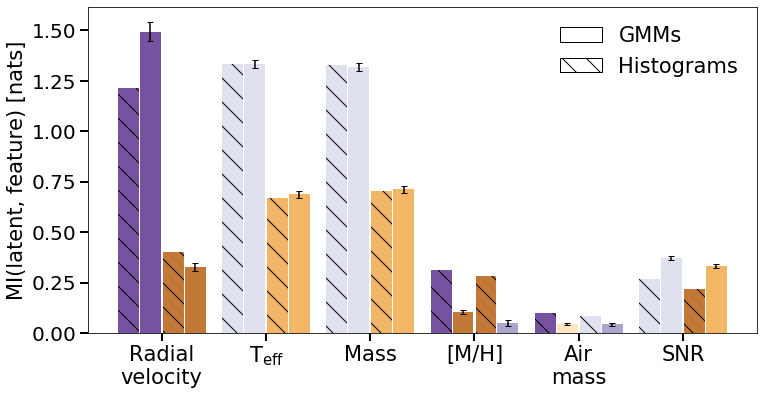

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
width = 0.8/4
alpha = 0.8
yerr_mul = 1
x = np.arange(len(label_list))  # the label locations

rects1 = ax.bar(x+width/2+0.01 , 
                np.choose(sorted_args_sed[:, 0], sed_MI.T), 
                width, color=np.choose(sorted_args_sed[:, 0], latent_colour_scheme),
                alpha=alpha, hatch='\\'
                #yerr=np.choose(sorted_args[:, 1], all_MI_estimates_s.T),
     )

rects1 = ax.bar(x - 1.5*width-2*0.01, 
                np.choose(sorted_args_sed[:, 1], sed_MI.T), 
                width, color=np.choose(sorted_args_sed[:, 1], latent_colour_scheme),
                alpha=alpha, hatch='\\',
                #yerr=np.choose(sorted_args[:, 1], all_MI_estimates_s.T),
     )

rects2 = ax.bar(x - width/2-0.01, 
                np.choose(sorted_args[:, 1], all_MI_estimates_m.T), 
                width, color=np.choose(sorted_args[:, 1], latent_colour_scheme),
                alpha=alpha,
                yerr=yerr_mul*np.choose(sorted_args[:, 1], all_MI_estimates_s.T), capsize=3
     )
rects3 = ax.bar(x + 1.5*width+2*0.01, 
       [value*1 if value < 0.01 else value for value in np.choose(sorted_args[:, 0], all_MI_estimates_m.T) ], 
        width, color=np.choose(sorted_args[:, 0], latent_colour_scheme),
                alpha=alpha, yerr=yerr_mul*np.choose(sorted_args[:, 0], all_MI_estimates_s.T), capsize=3

     )
    
#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

ax.tick_params(axis='x', which='major', labelsize=21, length=10, width=2, size=8)
ax.tick_params(axis='y', which='major', labelsize=20, length=10, width=2, size=8)
ax.set_ylabel(f'MI(latent, feature) [nats]', fontsize=21)

ax.set_xticks(x)
ax.set_xticklabels(label_list)

# build legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor=latent_colour_scheme[i], label=f'Latent {i+1}') for i in range(6)]

#leg = ax.legend(handles=legend_elements, fontsize=30, frameon=False);
#for lh in leg.legendHandles: 
#    lh.set_alpha(alpha)
#fig.savefig('./figures/MI_shapes3D.pdf', bbox_inches='tight');

import matplotlib.patches as mpatches

w_patch = mpatches.Patch(edgecolor='black', facecolor='white', label='GMMs')
wh_patch = mpatches.Patch(edgecolor='black', facecolor='white', hatch='\\', label='Histograms')

plt.legend(handles=[w_patch, wh_patch], fontsize=21, frameon=False)

# Validation

### D1

In [643]:
knn_estimates = np.load('./mine-pytorch/mine/D1_knn.npy')
mine_estimates = np.load('./mine-pytorch/mine/D1_mine.npy')
all_MI_estimates = np.load('./mine-pytorch/mine/D1_ours.npy')
analytic = np.load('./mine-pytorch/mine/D1_analytic.npy')

rhos = np.linspace(-0.99, 0.99, 20)

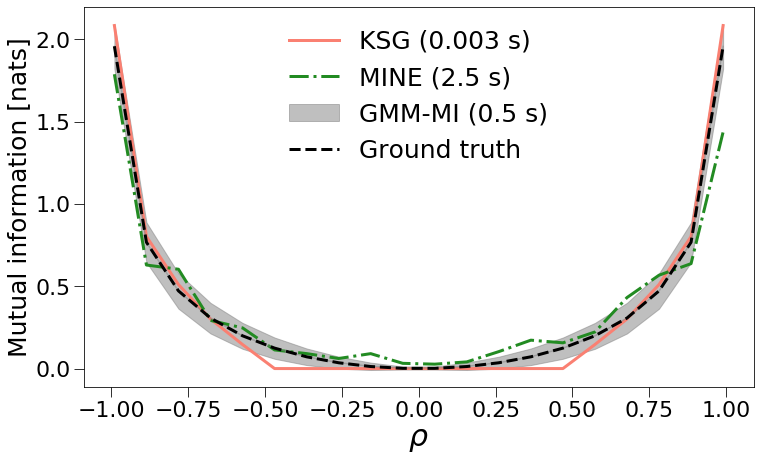

In [644]:
# let's plot all of this
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

sigmas = 2
lw=3
label = '$N=200$ samples to fit, 20 bootstrap realisations'
ax.tick_params(axis='both', which='major', labelsize=22, size=10)
ax.plot(rhos, knn_estimates, c='salmon', lw=lw, label='KSG (0.003 s)')
ax.plot(rhos, mine_estimates, c='forestgreen', ls='-.', lw=lw, label='MINE (2.5 s)')
ax.plot(rhos, all_MI_estimates[:, 0], color='grey', alpha=0.5)
ax.fill_between(rhos, all_MI_estimates[:, 0] - sigmas*all_MI_estimates[:, 1], all_MI_estimates[:, 0]+sigmas*all_MI_estimates[:, 1], color='grey', alpha=0.5, label='GMM-MI (0.5 s)')
ax.plot(rhos, analytic, ls='--', c='black', lw=lw, label='Ground truth')

handles, labels = ax.get_legend_handles_labels()
i1, i2 = -1, -2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 

#ax.set_title(label, fontsize=30)
ax.legend(handles, labels, fontsize=25, frameon=False)
        
ax.set_xlabel(r'$\rho$', fontsize=30)
ax.set_ylabel('Mutual information [nats]', fontsize=25);

#ax.set_yscale('log')
#ax.set_ylim((1e-5, 2))

plt.savefig('./figures/D1_comparison.pdf',  bbox_inches='tight');

In [17]:
all_MI_estimates[:, 1]

array([0.06783154, 0.06072041, 0.05360693, 0.04649349, 0.0393834 ,
       0.03228192, 0.02519866, 0.01815431, 0.01119692, 0.00458583,
       0.00458583, 0.01119692, 0.01815431, 0.02519866, 0.03228192,
       0.0393834 , 0.04649349, 0.05360693, 0.06072041, 0.06783154])

### D3

In [79]:
knn_estimates = np.load('./mine-pytorch/mine/D3_knn.npy')
mine_estimates = np.load('./mine-pytorch/mine/D3_mine.npy')
all_MI_estimates = np.load('./mine-pytorch/mine/D3_ours.npy')
analytic = np.load('./mine-pytorch/mine/D3_analytic.npy')

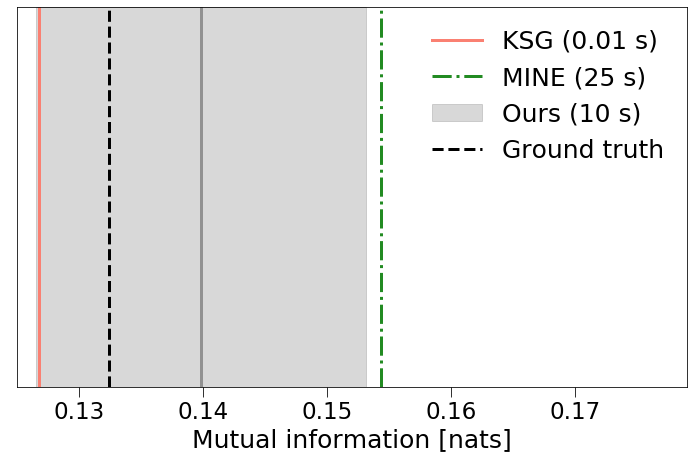

In [80]:
# let's plot all of this
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

lw=3
label = '$N=200$ samples to fit, 20 bootstrap realisations'
ax.tick_params(axis='both', which='major', labelsize=23, size=10)
ax.axvline(knn_estimates, c='salmon', lw=lw, label='KSG (0.01 s)')
ax.axvline(mine_estimates, c='forestgreen', ls='-.', lw=lw, label='MINE (25 s)')

ax.axvline(all_MI_estimates[:, 0], color='grey', alpha=0.8, lw=3)
ax.axvspan(all_MI_estimates[:, 0] - all_MI_estimates[:, 1], all_MI_estimates[:, 0]+all_MI_estimates[:, 1], color='grey', alpha=0.3, label='Ours (10 s)')
ax.axvline(analytic, ls='--', c='black', lw=lw, label='Ground truth')

handles, labels = ax.get_legend_handles_labels()
i1, i2 = -1, -2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 

#ax.set_title(label, fontsize=30)
ax.legend(handles, labels, fontsize=25, frameon=False)
        
ax.set_xlim((0.125, 0.179))
        
ax.axes.yaxis.set_ticks([])
ax.set_ylim((0.38, 0.62))
ax.set_xlabel('Mutual information [nats]', fontsize=25);

plt.savefig('./figures/D3_comparison.pdf',  bbox_inches='tight');

In [639]:
chi2 = np.load('./D3_chi2_final_bis.npy')
biases = np.load('./D3_biases_final_bis.npy')
bad_idx = biases>-10 #np.load('./D3_bad_idx.npy')

#chi2 = chi2[500:]
#biases = biases[500:]

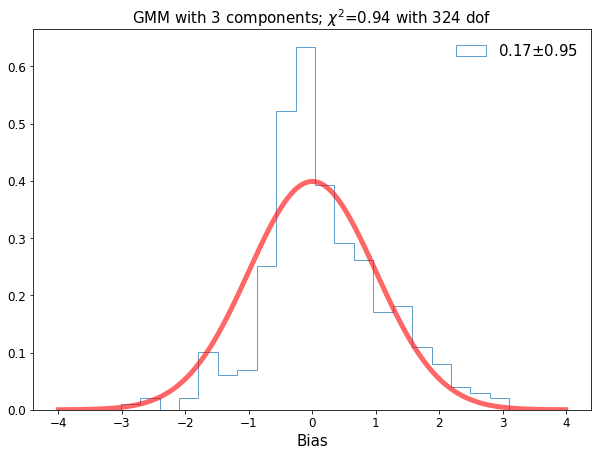

In [640]:

df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))

#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=20, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}',  density='True')
x = np.linspace(-4, 4, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {3} components; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);


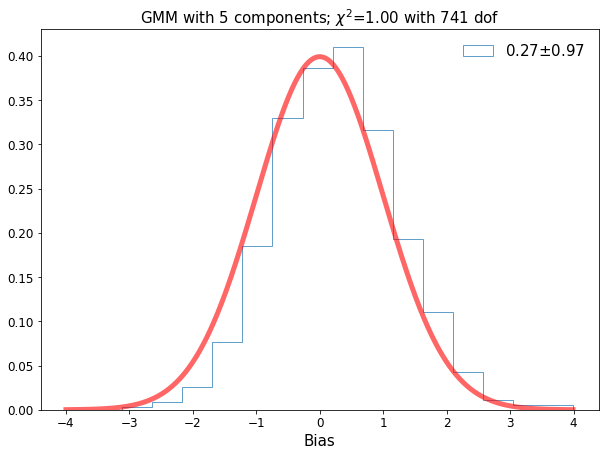

In [634]:
chi2 = np.load('./D5_chi2_final_bis.npy')
biases = np.load('./D5_biases_final_bis.npy')
bad_idx = np.load('./D5_bad_idx_bis.npy')

#chi2 = chi2[bad_idx]#:]#[np.argsort(np.abs(chi2-1))[:500]]
#biases = biases[bad_idx]#[np.argsort(np.abs(chi2-1))[:500]]

df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))
bins=15
#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=bins, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', density='True')
x = np.linspace(-4, 4, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {5} components; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);


In [574]:
np.argsort(np.abs(chi2-1))[:100]

array([ 32, 139, 522, 523,   3,  36,  67, 189, 344, 343, 417,  53, 254,
       476, 459, 300, 462, 356, 618, 431, 145, 366, 616, 629, 384, 163,
       473, 645, 177,  25, 582, 199, 513, 202, 533, 333, 467, 393,  28,
       494, 531, 105, 619, 641,  34, 277, 447,  18, 129, 317, 289, 664,
       605, 452,  73,  52, 251, 322, 197, 607, 469, 319, 576, 297, 276,
       136, 390,   4, 659, 305, 359, 173, 326, 348, 347, 115,  31,  80,
       233, 133, 168, 101, 248, 179,   7, 426, 132, 613, 262,  23, 592,
       111,  79, 391, 330, 328, 509, 502, 420, 196])

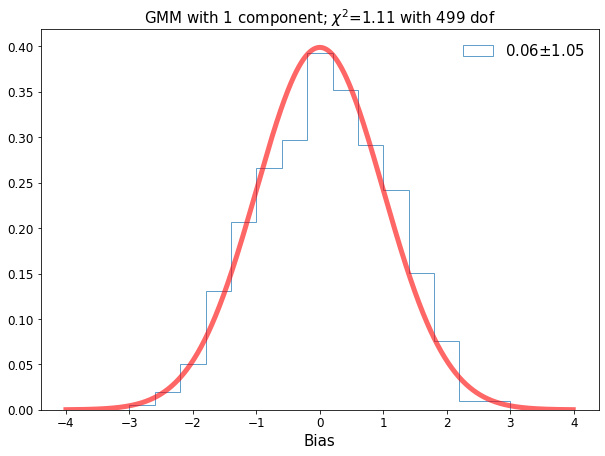

In [612]:
chi2 = np.load('./D1_chi2_final.npy')
biases = np.load('./D1_biases_final.npy')
bad_idx = np.load('./D1_bad_idx.npy')

chi2 = chi2[500:]
biases = biases[500:]

df = len(chi2)-1
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 7))
bins=15
#ax.errorbar(random_states, np.mean(MI_estimates, axis=1), np.sqrt(np.var(MI_estimates, axis=1)), fmt='x', color='salmon', label='Bootstrap')

ax1.hist(np.array(biases).flatten(), histtype='step', alpha=0.7, bins=bins, label=f'{np.mean(biases):.2f}$\pm${np.std(biases):.2f}', range=(-3, 3), density='True')
x = np.linspace(-4, 4, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Bias', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=15, frameon=False)
ax1.plot(x, y,
       'r-', lw=5, alpha=0.6, label='Gaussian pdf')
ax1.set_title(f'GMM with {1} component; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);


### D5

In [435]:
knn_estimates = np.load('./mine-pytorch/mine/D5_knn.npy')
mine_estimates = np.load('./mine-pytorch/mine/D5_mine.npy')
all_MI_estimates = np.load('./mine-pytorch/mine/D5_ours.npy')
analytic = np.load('./mine-pytorch/mine/D5_analytic.npy')

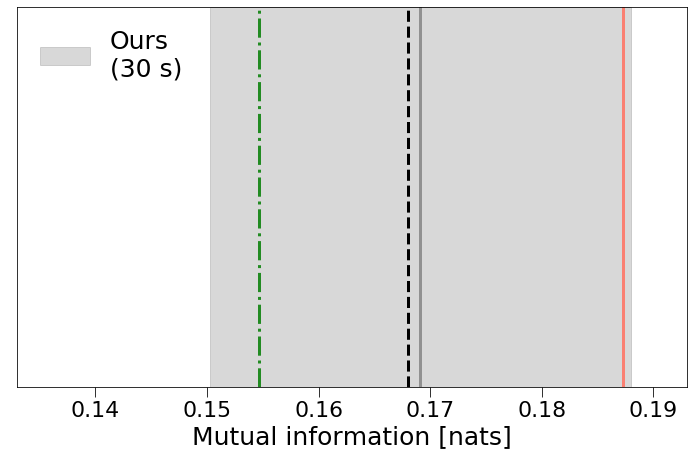

In [75]:
# let's plot all of this
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

lw=3
label = '$N=200$ samples to fit, 20 bootstrap realisations'
ax.tick_params(axis='both', which='major', labelsize=22, size=10)
#ax.axvline(knn_estimates, c='salmon', lw=lw, label='KSG (0.01 s)')
ax.axvline(knn_estimates, c='salmon', lw=lw)
#ax.axvline(mine_estimates, c='forestgreen', ls='-.', lw=lw, label='MINE (25 s)')
ax.axvline(mine_estimates, c='forestgreen', ls='-.', lw=lw)

ax.axvline(all_MI_estimates[:, 0], color='grey', alpha=0.8, lw=3)
ax.axvspan(all_MI_estimates[:, 0] - all_MI_estimates[:, 1], all_MI_estimates[:, 0]+all_MI_estimates[:, 1], color='grey', alpha=0.3, label='Ours\n(30 s)')
#ax.errorbar( np.mean(MI_estimates), 0.5, 0, np.std(MI_estimates), fmt='.', markersize=20, color='grey', capsize=10, elinewidth=2, label='Ours (30 s)')
#ax.axvline(analytic, ls='--', c='black', lw=lw, label='Ground truth')
ax.axvline(analytic, ls='--', c='black', lw=lw)


#handles, labels = ax.get_legend_handles_labels()
#i1, i2 = -1, -2
#handles[i1], handles[i2] = handles[i2], handles[i1] 
#labels[i1], labels[i2] = labels[i2], labels[i1] 

#ax.set_title(label, fontsize=30)
ax.legend(fontsize=25, frameon=False, loc='upper left')
        
ax.set_xlim((0.133, 0.193))
        
ax.axes.yaxis.set_ticks([])
ax.set_ylim((0.38, 0.62))
ax.set_xlabel('Mutual information [nats]', fontsize=25);

plt.savefig('./figures/D5_comparison.pdf',  bbox_inches='tight');

### All residuals

In [201]:
def load_data(dataset, suffix):
    chi2 = np.load(f'./{dataset}_chi2_{suffix}.npy')
    biases = np.load(f'./{dataset}_biases_{suffix}.npy')
    return chi2, biases

#bad_idx = np.load('./D1_bad_idx.npy')

ranges = 3
bins = 20
size = 1001

chi2_d1, biases_d1 = load_data('D1', 'final')
chi2_d1_, biases_d1_ = load_data('D1', 'final_bis')
chi2_d1 = np.concatenate((chi2_d1, chi2_d1_))
biases_d1 = np.concatenate((biases_d1, biases_d1_))

idx = np.random.choice(np.arange(len(chi2_d1)), size)
chi2_d1 = chi2_d1[idx]
biases_d1 = biases_d1[idx]


chi2_d3, biases_d3 = load_data('D3', 'final_bis')
chi2_d5, biases_d5 = load_data('D5', 'final_bis')

In [117]:
best_chi = 2

for _ in range(500):
    chi2_d1, biases_d1 = load_data('D1', 'final')
    chi2_d1_, biases_d1_ = load_data('D1', 'final_bis')
    chi2_d1 = np.concatenate((chi2_d1, chi2_d1_))
    biases_d1 = np.concatenate((biases_d1, biases_d1_))

    idx = np.random.choice(np.arange(len(chi2_d1)), size)
    chi2_d1 = chi2_d1[idx]
    biases_d1 = biases_d1[idx]
    df = len(chi2_d1)-1
    chired = np.sum(chi2_d1)/df
    if np.abs(chired - 1) < best_chi:
        best_chi = np.abs(chired - 1)
        best_idx = idx
        print(best_chi)

0.19847074311116542
0.1457350449630217
0.10780375203902626
0.052131167357787556
0.03247221006508649


In [223]:
chi2_d1, biases_d1 = load_data('D1', 'final')
chi2_d1_, biases_d1_ = load_data('D1', 'final_bis')
chi2_d1 = np.concatenate((chi2_d1, chi2_d1_))
biases_d1 = np.concatenate((biases_d1, biases_d1_))
#chi2_d1 = chi2_d1[best_idx]
#biases_d1 = biases_d1[best_idx]

In [224]:
#best_idx_1 = np.copy(best_idx)
chi2_d1 = chi2_d1[best_idx_1]
biases_d1 = biases_d1[best_idx_1]

0.06$\pm$1.05,
$\chi^2_{{red}}$=1.11 with 500 dof


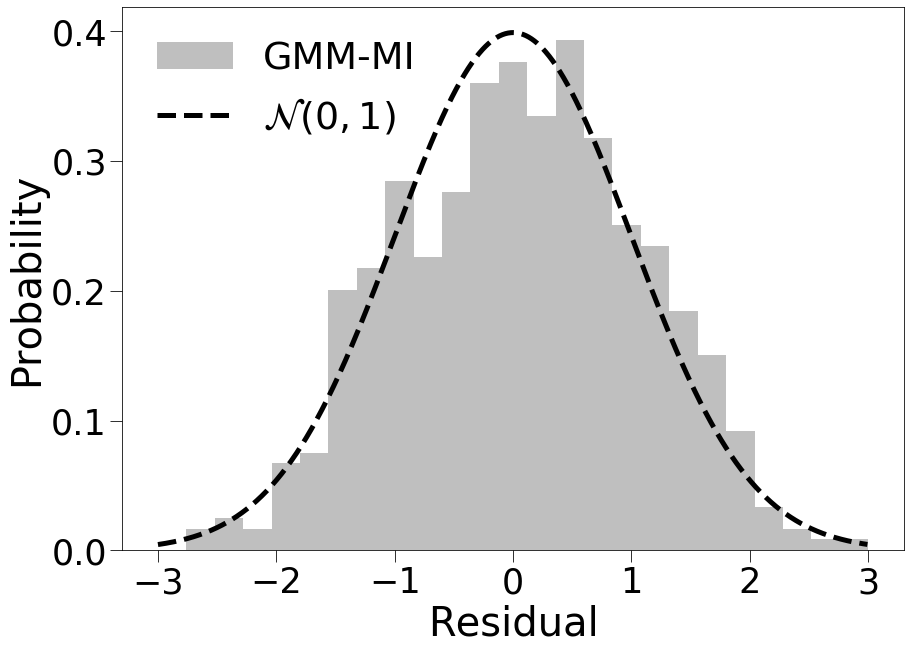

In [259]:
chi2_d1, biases_d1 = load_data('D1', 'final')
chi2_d1 = chi2_d1[499:]
biases_d1 = biases_d1[499:]

df = len(chi2_d1)-1
#print(df)
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))
bins=25
alpha=0.5
legendsize=38

ax1.hist(np.array(biases_d1).flatten(), alpha=alpha, bins=bins, 
         label='GMM-MI', color='grey', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d3).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D3, {np.mean(biases_d3):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d3)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d5).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D5, {np.mean(biases_d5):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d5)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')

         
print(f'{np.mean(biases_d1):.2f}$\pm${np.std(biases):.2f},\n$\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof')



x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Residual', fontsize=40)
ax1.set_ylabel('Probability', fontsize=40)

ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.plot(x, y, c='black', ls='--', lw=5, alpha=1, label=r'$\mathcal{N}(0, 1)$')
#ax1.set_title(f'GMM with {1} component; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

handles, labels = ax1.get_legend_handles_labels()
i1, i2 = -1, -2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 


ax1.tick_params(axis='both', which='major', labelsize=35, size=12)
ax1.legend(handles, labels, fontsize=legendsize, frameon=False, loc='upper left')

plt.savefig('./figures/D1_residuals.pdf',  bbox_inches='tight');

0.06$\pm$0.96,
$\chi^2_{{red}}$=0.93 with 500 dof


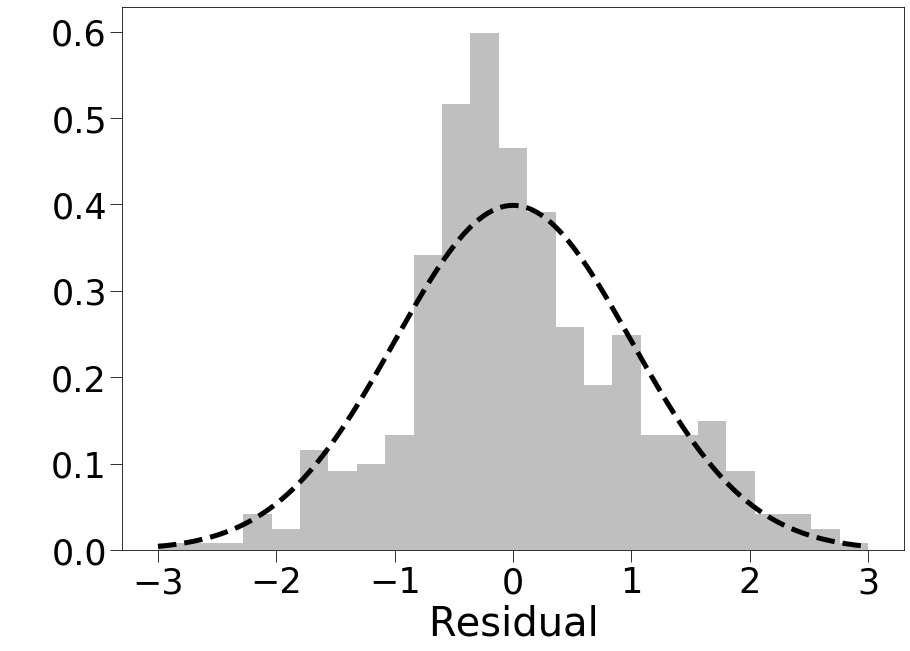

In [249]:
chi2_d1, biases_d1 = load_data('D3', 'final')
chi2_d1 = chi2_d1[499:]
biases_d1 = biases_d1[499:]

df = len(chi2_d1)-1
#print(df)
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))
bins=25
alpha=0.5
legendsize=38

ax1.hist(np.array(biases_d1).flatten(), alpha=alpha, bins=bins, 
         label='GMM-MI', color='grey', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d3).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D3, {np.mean(biases_d3):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d3)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d5).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D5, {np.mean(biases_d5):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d5)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')

         
print(f'{np.mean(biases_d1):.2f}$\pm${np.std(biases_d1):.2f},\n$\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof')


x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Residual', fontsize=40)
ax1.set_ylabel('Probability', fontsize=40, color='white')

ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.plot(x, y, c='black', ls='--', lw=5, alpha=1, label=r'$\mathcal{N}(0, 1)$')
#ax1.set_title(f'GMM with {1} component; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

ax1.tick_params(axis='both', which='major', labelsize=35, size=12)
#ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')

plt.savefig('./figures/D3_residuals.pdf',  bbox_inches='tight');

0.28$\pm$0.96,
$\chi^2_{{red}}$=0.99 with 500 dof


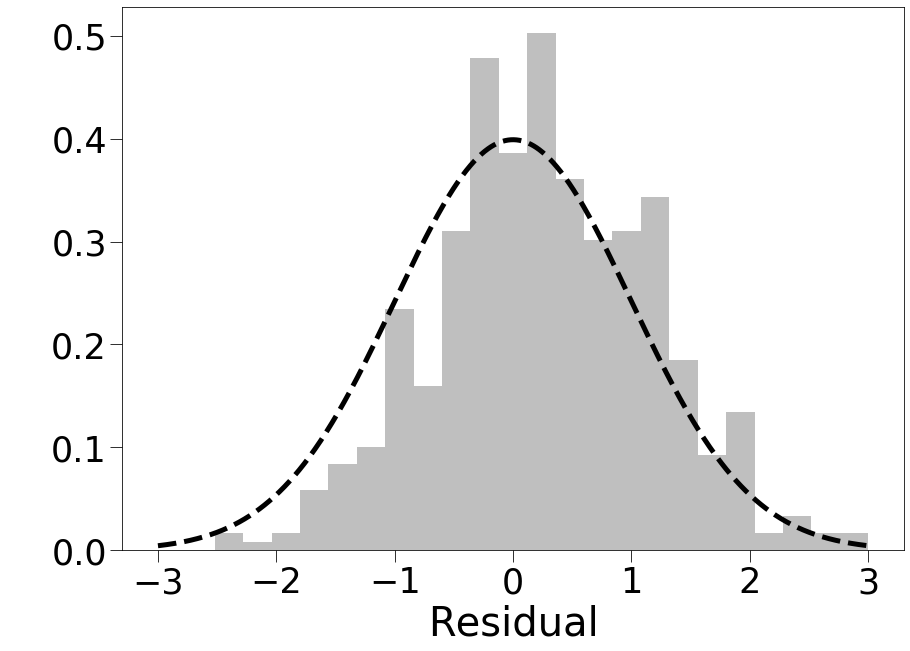

In [255]:
chi2_d1, biases_d1 = load_data('D5', 'final_bis')
chi2_d1 = chi2_d1[150:651]
biases_d1 = biases_d1[150:651]

df = len(chi2_d1)-1
#print(df)
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))
bins=25
alpha=0.5
legendsize=38

ax1.hist(np.array(biases_d1).flatten(), alpha=alpha, bins=bins, 
         label='GMM-MI', color='grey', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d3).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D3, {np.mean(biases_d3):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d3)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d5).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D5, {np.mean(biases_d5):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d5)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')

         
print(f'{np.mean(biases_d1):.2f}$\pm${np.std(biases_d1):.2f},\n$\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f} with {df} dof')


x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Residual', fontsize=40)
ax1.set_ylabel('Probability', fontsize=40, color='white')

ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.plot(x, y, c='black', ls='--', lw=5, alpha=1, label=r'$\mathcal{N}(0, 1)$')
#ax1.set_title(f'GMM with {1} component; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

ax1.tick_params(axis='both', which='major', labelsize=35, size=12)
#ax1.legend(fontsize=legendsize, frameon=False, loc='upper left')

plt.savefig('./figures/D5_residuals.pdf',  bbox_inches='tight');

In [209]:
chi2_d3, biases_d3 = load_data('D3', 'final')
chi2_d3_, biases_d3_ = load_data('D3', 'final_bis')
chi2_d3 = np.concatenate((chi2_d3, chi2_d3_))
biases_d3 = np.concatenate((biases_d3, biases_d3_))

In [210]:
best_chi = 2

for _ in range(10):
    chi2_d3, biases_d3 = load_data('D3', 'final')
    chi2_d3_, biases_d3_ = load_data('D3', 'final_bis')
    chi2_d3 = np.concatenate((chi2_d3, chi2_d3_))
    biases_d3 = np.concatenate((biases_d3, biases_d3_))

    idx = np.random.choice(np.arange(len(chi2_d3)), size)
    chi2_d3 = chi2_d3[idx]
    biases_d3 = biases_d3[idx]
    df = len(chi2_d3)-1
    chired = np.sum(chi2_d3)/df
    if np.abs(chired - 1) < best_chi:
        best_chi = np.abs(chired - 1)
        best_idx = idx
        print(best_chi)

0.15266650480285815
0.026014493753173662
0.010836793544922507


In [211]:
chi2_d1, biases_d1 = load_data('D3', 'final')
chi2_d1_, biases_d1_ = load_data('D3', 'final_bis')
chi2_d1 = np.concatenate((chi2_d1, chi2_d1_))
biases_d1 = np.concatenate((biases_d1, biases_d1_))
chi2_d1 = chi2_d1[best_idx]
biases_d1 = biases_d1[best_idx]

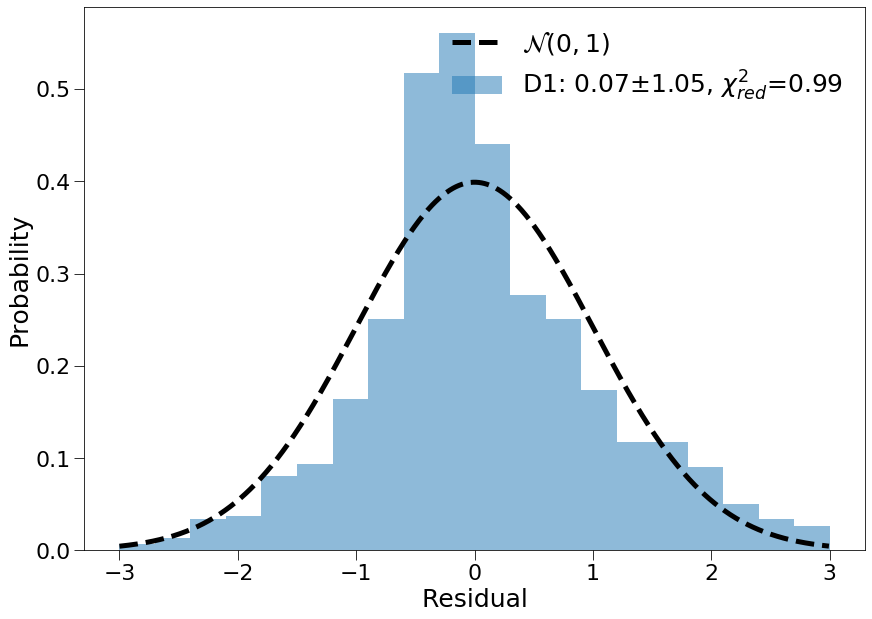

In [212]:
df = len(chi2_d1)-1
#print(df)
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))
bins=20
alpha=0.5
legendsize=25

ax1.hist(np.array(biases_d1).flatten(), alpha=alpha, bins=bins, 
         label=f'D1: {np.mean(biases_d1):.2f}$\pm${np.std(biases):.2f}, $\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f}', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d3).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D3, {np.mean(biases_d3):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d3)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d5).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D5, {np.mean(biases_d5):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d5)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')



x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Residual', fontsize=25)
ax1.set_ylabel('Probability', fontsize=25)

ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.plot(x, y, c='black', ls='--', lw=5, alpha=1, label=r'$\mathcal{N}(0, 1)$')
#ax1.set_title(f'GMM with {1} component; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

ax1.tick_params(axis='both', which='major', labelsize=22, size=10)
ax1.legend(fontsize=legendsize, frameon=False);

In [213]:
chi2_d5, biases_d5 = load_data('D5', 'final')
chi2_d5_, biases_d5_ = load_data('D5', 'final_bis')
chi2_d5 = np.concatenate((chi2_d5, chi2_d5_))
biases_d5 = np.concatenate((biases_d5, biases_d5_))

In [215]:
best_chi = 2

for _ in range(2000):
    chi2_d5, biases_d5 = load_data('D5', 'final')
    chi2_d5_, biases_d5_ = load_data('D5', 'final_bis')
    chi2_d5 = np.concatenate((chi2_d5, chi2_d5_))
    biases_d5 = np.concatenate((biases_d5, biases_d5_))

    idx = np.random.choice(np.arange(len(chi2_d5)), size)
    chi2_d5 = chi2_d5[idx]
    biases_d5 = biases_d5[idx]
    df = len(chi2_d5)-1
    chired = np.sum(chi2_d5)/df
    if np.abs(chired-1) < best_chi:
        best_chi = np.abs(chired-1)
        best_idx = idx
        print(best_chi)

0.11051845908903668
0.08601656843908956
0.07440099503913578
0.035037354922263786
0.02277718272388274
0.019257620092420713
0.012441612106334987
0.002404231425676251
0.00029434387015703223
0.0001955999454508195


In [216]:
chi2_d1, biases_d1 = load_data('D5', 'final')
chi2_d1_, biases_d1_ = load_data('D5', 'final_bis')
chi2_d1 = np.concatenate((chi2_d1, chi2_d1_))
biases_d1 = np.concatenate((biases_d1, biases_d1_))
chi2_d1 = chi2_d1[best_idx]
biases_d1 = biases_d1[best_idx]

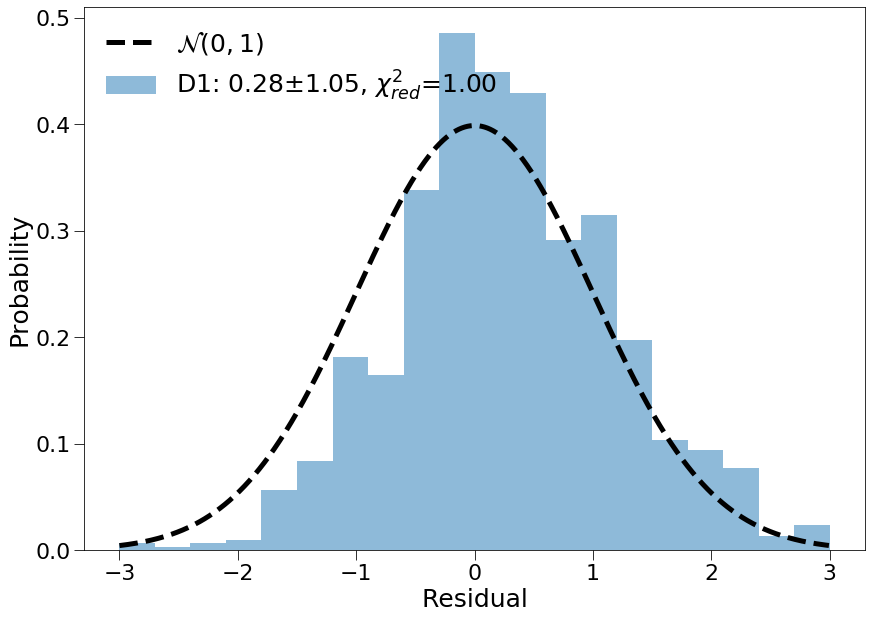

In [217]:
df = len(chi2_d1)-1
#print(df)
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 10))
bins=20
alpha=0.5
legendsize=25

ax1.hist(np.array(biases_d1).flatten(), alpha=alpha, bins=bins, 
         label=f'D1: {np.mean(biases_d1):.2f}$\pm${np.std(biases):.2f}, $\chi^2_{{{{red}}}}$={np.sum(chi2_d1)/df:.2f}', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d3).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D3, {np.mean(biases_d3):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d3)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')
#ax1.hist(np.array(biases_d5).flatten(), histtype='step', alpha=alpha, bins=bins, 
#         label=f'D5, {np.mean(biases_d5):.2f}$\pm${np.std(biases):.2f}, $\chi^2$={np.sum(chi2_d5)/df:.2f} with {df} dof', range=(-ranges, ranges), density='True')



x = np.linspace(-3, 3, 1000, endpoint=False)
y = multivariate_normal.pdf(x, mean=0, cov=1)
ax1.set_xlabel('Residual', fontsize=25)
ax1.set_ylabel('Probability', fontsize=25)

ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.plot(x, y, c='black', ls='--', lw=5, alpha=1, label=r'$\mathcal{N}(0, 1)$')
#ax1.set_title(f'GMM with {1} component; $\chi^2$={np.sum(chi2)/df:.2f} with {df} dof', fontsize=15);

ax1.tick_params(axis='both', which='major', labelsize=22, size=10)
ax1.legend(fontsize=legendsize, frameon=False);

### Bootstrap

In [7]:
knn_estimates_bs = np.load('./mine-pytorch/mine/bs_knn.npy')
mine_estimates_bs = np.load('./mine-pytorch/mine/bs_mine.npy')
MI_estimates = np.load('./mine-pytorch/mine/bs_ours.npy')
MI_analytical = np.load('./mine-pytorch/mine/bs_analytic.npy')

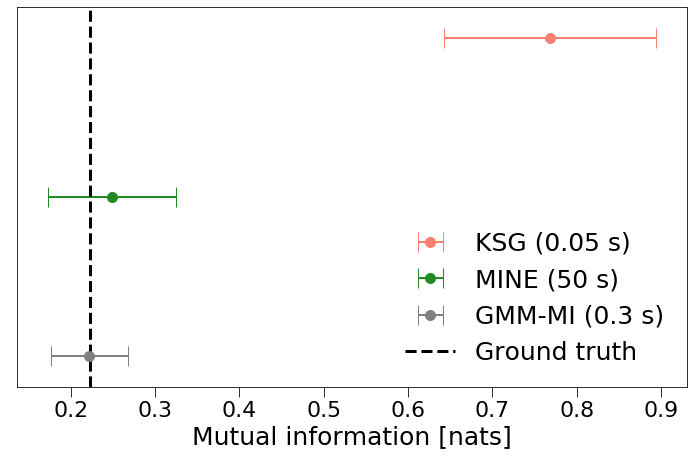

In [8]:
# let's plot all of this
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

np.mean(knn_estimates_bs), np.std(knn_estimates_bs)

sigmas = 1
label = '$N=200$ samples to fit, 20 bootstrap realisations'
ax.tick_params(axis='both', which='major', labelsize=22, size=10)
ax.errorbar(np.mean(knn_estimates_bs), 0.6, xerr=sigmas*np.std(knn_estimates_bs), yerr=None,  fmt='.', markersize=20, color='salmon', capsize=10, elinewidth=2, label='KSG (0.05 s)')
ax.errorbar(np.mean(mine_estimates_bs), 0.5, xerr=sigmas*np.std(mine_estimates_bs), yerr=None, fmt='.', markersize=20, color='forestgreen', capsize=10, elinewidth=2, label='MINE (50 s)')
ax.errorbar( np.mean(MI_estimates), 0.4, yerr=None, xerr=sigmas*np.std(MI_estimates), fmt='.', markersize=20, color='grey', capsize=10, elinewidth=2, label='GMM-MI (0.3 s)')
#ax.errorbar( np.mean(true_estimates_bs), 0.3, yerr=None, xerr=np.std(true_estimates_bs), fmt='.', markersize=20, color='grey', capsize=10, elinewidth=2, label='True')
ax.axvline(MI_analytical, 0, linestyle='--', lw=3, color='k', label='Ground truth')

handles, labels = ax.get_legend_handles_labels()
i1, i2 = 0, 1
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 

i1, i2 = 1, 2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 

i1, i2 = 2, 3
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1]

#i1, i2 = 3, 4
#handles[i1], handles[i2] = handles[i2], handles[i1] 
#labels[i1], labels[i2] = labels[i2], labels[i1]

#ax.set_title(label, fontsize=30)
ax.legend(handles, labels, fontsize=25, frameon=False, loc='lower right')
        
ax.axes.yaxis.set_ticks([])
ax.set_ylim((0.38, 0.62))

#ax.set_xscale('log')

ax.set_xlabel('Mutual information [nats]', fontsize=25);
plt.savefig('./figures/MI_bootstrap.pdf',  bbox_inches='tight');

### Gamma exp

In [235]:
knn_estimates = np.load('./mine-pytorch/mine/gamma_exp_knn.npy')
mine_estimates = np.load('./mine-pytorch/mine/gamma_exp_mine.npy')
all_MI_estimates = np.load('./mine-pytorch/mine/gamma_exp_ours.npy')
analytic = np.load('./mine-pytorch/mine/gamma_exp_analytic.npy')

thetas = np.logspace(-1, 2, 20)

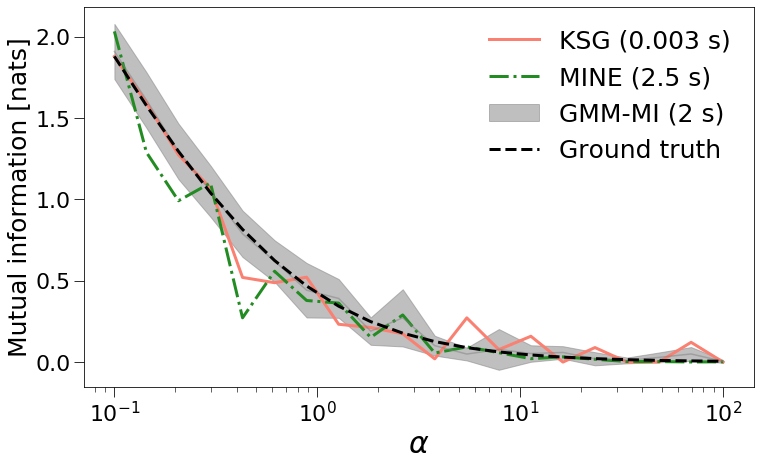

In [236]:
# let's plot all of this
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

sigmas = 2
lw=3
label = '$N=200$ samples to fit, 20 bootstrap realisations'
ax.tick_params(axis='both', which='major', labelsize=22, size=10)
ax.tick_params(axis='both', which='minor', labelsize=22, size=5)
ax.plot(thetas, knn_estimates, c='salmon', lw=lw, label='KSG (0.003 s)')
ax.plot(thetas, mine_estimates, c='forestgreen', ls='-.', lw=lw, label='MINE (2.5 s)')
ax.plot(thetas, all_MI_estimates[:, 0], color='grey', alpha=0.5)
ax.fill_between(thetas, all_MI_estimates[:, 0] - sigmas*all_MI_estimates[:, 1], all_MI_estimates[:, 0]+sigmas*all_MI_estimates[:, 1], color='grey', alpha=0.5, label='GMM-MI (2 s)')
ax.plot(thetas, analytic, ls='--', c='black', lw=lw, label='Ground truth')

handles, labels = ax.get_legend_handles_labels()
i1, i2 = -1, -2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 

#ax.set_title(label, fontsize=30)
ax.legend(handles, labels, fontsize=25, frameon=False)
        
ax.set_xlabel(r'$\alpha$', fontsize=30)
ax.set_ylabel('Mutual information [nats]', fontsize=25);

ax.set_xscale('log')
#ax.set_ylim((1e-5, 2))

plt.savefig('./figures/gamma_exp_comparison.pdf',  bbox_inches='tight');

### Exp exp

In [237]:
knn_estimates = np.load('./mine-pytorch/mine/exp_exp_knn.npy')
mine_estimates = np.load('./mine-pytorch/mine/exp_exp_mine.npy')
all_MI_estimates = np.load('./mine-pytorch/mine/exp_exp_ours.npy')
analytic = np.load('./mine-pytorch/mine/exp_exp_analytic.npy')

thetas = np.logspace(-1, 2, 20)

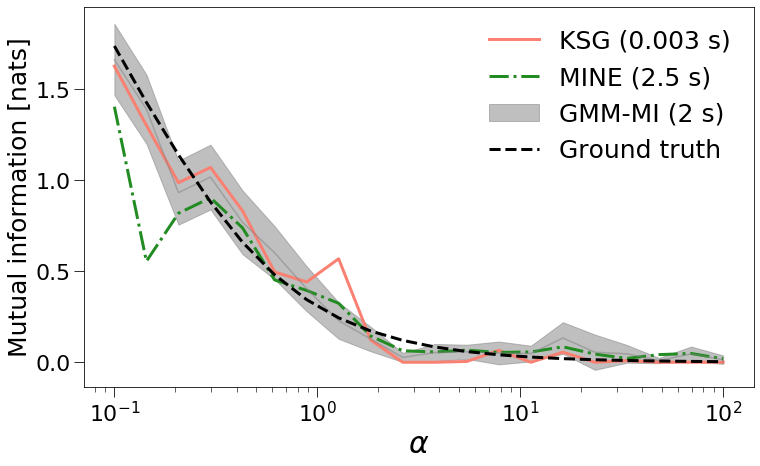

In [238]:
# let's plot all of this
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

sigmas = 2
lw=3
ax.tick_params(axis='both', which='major', labelsize=22, size=10)
ax.tick_params(axis='both', which='minor', labelsize=22, size=5)
ax.plot(thetas, knn_estimates, c='salmon', lw=lw, label='KSG (0.003 s)')
ax.plot(thetas, mine_estimates, c='forestgreen', ls='-.', lw=lw, label='MINE (2.5 s)')
ax.plot(thetas, all_MI_estimates[:, 0], color='grey', alpha=0.5)
ax.fill_between(thetas, all_MI_estimates[:, 0] - sigmas*all_MI_estimates[:, 1], all_MI_estimates[:, 0]+sigmas*all_MI_estimates[:, 1], color='grey', alpha=0.5, label='GMM-MI (2 s)')
ax.plot(thetas, analytic, ls='--', c='black', lw=lw, label='Ground truth')

handles, labels = ax.get_legend_handles_labels()
i1, i2 = -1, -2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 

#ax.set_title(label, fontsize=30)
ax.legend(handles, labels, fontsize=25, frameon=False)
        
ax.set_xlabel(r'$\alpha$', fontsize=30)
ax.set_ylabel('Mutual information [nats]', fontsize=25);

ax.set_xscale('log')
#ax.set_ylim((1e-5, 2))

plt.savefig('./figures/exp_exp_comparison.pdf',  bbox_inches='tight');